<a href="https://colab.research.google.com/github/ppannala/SFDC-Ship/blob/master/NLP_Project_Full_Code_LLM_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Please read the instructions carefully before starting the project.**

**Note**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:

1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.

2. Switch to a different Google account and resume working on the project from there.

3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

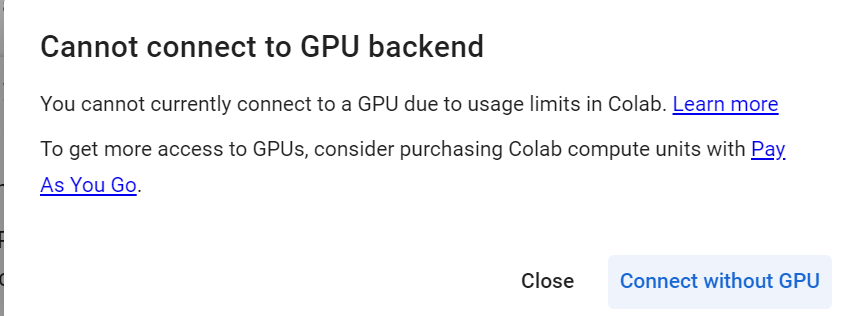

## **Installing and Importing Necessary Libraries**

In [1]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 22.1 MB/s eta 0:00:00


In [2]:
# to read and manipulate the data
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', None)    # setting column to the maximum column width as per the data

# to visualise data
import matplotlib.pyplot as plt
import seaborn as sns

# to compute distances
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score

# importing the PyTorch Deep Learning library
import torch

# to import the model
from sentence_transformers import SentenceTransformer

# to cluster the data
from sklearn.cluster import KMeans

# to visualise data
import matplotlib.pyplot as plt
import seaborn as sns

# to use regular expressions for manipulating text data
import re

# to load the natural language toolkit
import nltk
nltk.download('stopwords')    # loading the stopwords
nltk.download('wordnet')    # loading the wordnet module that is used in stemming

# to remove common stop words
from nltk.corpus import stopwords

# to perform stemming
from nltk.stem.porter import PorterStemmer

# to create Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

# to import Word2Vec
from gensim.models import Word2Vec

# to split data into train and test sets
from sklearn.model_selection import train_test_split

# to build a Random Forest model
from sklearn.ensemble import RandomForestClassifier

# to compute metrics to evaluate the model
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

# To tune different models
from sklearn.model_selection import GridSearchCV

# to avoid displaying unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## **Loading the dataset**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
news = pd.read_csv("/content/drive/MyDrive/nlp/stock_news.csv")

In [5]:
# creating a copy of the data
data = news.copy()

## **Data Overview**

In [6]:
data.head()

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.",41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,"Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10",41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,"Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon",41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,"This news article reports that yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year on January 2, 2019, due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the partial U.S. government shutdown. Apple",41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,"Apple's revenue warning led to a decline in USD JPY pair and a gain in Japanese yen, as investors sought safety in the highly liquid currency. Apple's underperformance in Q1, with forecasted revenue of $84 billion compared to analyst expectations of $91.5 billion, triggered risk aversion mood in markets",41.740002,42.244999,41.482498,40.246914,130672400,-1


In [7]:
data.shape

(349, 8)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


In [9]:
data.describe()

,Open,High,Low,Close,Volume,Label
count,349.000000,349.000000,349.000000,349.000000,3.490000e+02,349.000000
mean,46.229233,46.700458,45.745394,44.926317,1.289482e+08,-0.054441
std,6.442817,6.507321,6.391976,6.398338,4.317031e+07,0.715119
min,37.567501,37.817501,37.305000,36.254131,4.544800e+07,-1.000000
25%,41.740002,42.244999,41.482498,40.246914,1.032720e+08,-1.000000
50%,45.974998,46.025002,45.639999,44.596924,1.156272e+08,0.000000
75%,50.707500,50.849998,49.777500,49.110790,1.511252e+08,0.000000
max,66.817497,67.062500,65.862503,64.805229,2.444392e+08,1.000000


In [10]:
data.Label.value_counts()

,count
Label,
0,170
-1,99
1,80


## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [11]:
# Installation for GPU llama-cpp-python
# uncomment and run the following code in case GPU is being used
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.85 --force-reinstall --no-cache-dir -q

# Installation for CPU llama-cpp-python
# uncomment and run the following code in case GPU is not being used
#!CMAKE_ARGS="-DLLAMA_CUBLAS=off" FORCE_CMAKE=1 pip install llama-cpp-python -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 36.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 209.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 175.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 206.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires numpy<2.0a0,>=1.23, but you have numpy 2.1.1 which is incompatible.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.1.1 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.1.1 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.1.1 which is incompatible.
p

In [12]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

#### Loading the model

In [13]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"

In [14]:
# Using hf_hub_download to download a model from the Hugging Face model hub
# The repo_id parameter specifies the model name or path in the Hugging Face repository
# The filename parameter specifies the name of the file to download
model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

mistral-7b-instruct-v0.2.Q6_K.gguf:   0%|          | 0.00/5.94G [00:00<?, ?B/s]

In [15]:
llm = Llama(
    model_path=model_path,
    n_gpu_layers=100,
    n_ctx=4500,
)

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


#### Aggregating the data weekly

In [16]:
data["Date"] = pd.to_datetime(data['Date'])  # Convert the 'Date' column to datetime format.

In [17]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

In [18]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [19]:
weekly_grouped

Date  \
0  2019-01-06   
1  2019-01-13   
2  2019-01-20   
3  2019-01-27   
4  2019-02-03   
5  2019-02-10   
6  2019-02-17   
7  2019-02-24   
8  2019-03-03   
9  2019-03-10   
10 2019-03-17   
11 2019-03-24   
12 2019-03-31   
13 2019-04-07   
14 2019-04-14   
15 2019-04-21   
16 2019-04-28   
17 2019-05-05   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [20]:
len(weekly_grouped.loc[0, 'News'])

16090

In [21]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

In [22]:
weekly_grouped['News'] = weekly_grouped['News'].apply(lambda x: x[:4500])

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

##### Utility Functions

In [23]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

##### Defining the response function

In [24]:
#Defining the response function
def response_mistral_1(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=400, #Complete the code to set the maximum number of tokens the model should generate for this task.
      temperature=.01, #Complete the code to set the value for temperature.
      top_p=9, #Complete the code to set the value for top_p
      top_k=40, #Complete the code to set the value for top_k
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output

##### Checking the model output on a sample

**Note**: Use this section to test out the prompt with one instance before using it for the entire weekly data.

In [25]:
# defining the instructions for the model
instruction_1 = """
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with JSON containing two keys, one for Positive Events and one for Negative Events.

Sample Output:

{"Positive": ["output1", "output2"], "Negative": ["output1", "output2"] }

Return only JSON response and do not return anything else
"""

In [27]:
response_mistral_1(instruction_1, weekly_grouped['News'].iloc[0])

'{"Positive": ["Roku Inc announcing plans to offer premium video channels", "RBC Capital maintaining bullish stance on Apple"], "Negative": ["Apple\'s significant decline in the aftermarket following revenue warning", "Weaker than expected iPhone sales", "Global economic concerns following weak data from China and Europe", "US-China trade tensions", "Massive stop loss sales triggered by Apple\'s earnings warning", "Falling stock prices of related suppliers", "Significant drops in major currencies like AUD and USD JPY"] }'

##### Checking the model output on the weekly data

In [28]:
weekly_grouped['Summary'] = weekly_grouped['News'].progress_apply(lambda x: response_mistral_1(instruction_1, x))

100%|██████████| 18/18 [03:25<00:00, 11.40s/it]


##### Formatting the model output

In [66]:
weekly_grouped_1 = weekly_grouped.copy()

In [68]:
#Apply the JSON extraction function and format output in a structured manner
weekly_grouped_1['Events'] = weekly_grouped_1['Summary'].apply(extract_json_data)

In [72]:
weekly_grouped_1.head(2)

Date  \
0 2019-01-06   
1 2019-01-13   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [70]:
json_parsed = pd.json_normalize(weekly_grouped_1['Events'])

In [71]:
json_parsed

,Positive,Negative
0,"[Roku Inc announcing plans to offer premium video channels, RBC Capital maintaining bullish stance on Apple]","[Apple's significant decline in the aftermarket following revenue warning, Weaker than expected iPhone sales, Global economic concerns following weak data from China and Europe, US-China trade tensions, Massive stop loss sales triggered by Apple's earnings warning, Falling stock prices of related suppliers, Significant drops in major currencies like AUD and USD JPY]"
1,"[Sprint and Samsung planning 5G smartphone release in nine cities, AMS developing new 3D facial recognition features for smartphones with Face, Deutsche Bank upgrading Universal Music Group valuation to €29 billion, Amazon stock predicted to surge by over 20%, Qualcomm expanding car computing chips lineup into three tiers, Mercedes Benz sold over 2.31 million passenger cars in 2018]","[Geely forecasting flat sales for 2019, China making efforts to address U.S. concerns but cannot dismantle governance model, Stock index futures indicating slightly lower open on Wall Street Monday, Economic growth concerns emerging in Europe, Chinese smartphone market saw a decline of 12-15.5 percent in shipments last year, AT S lowered revenue growth forecast for 2018/19 due to weak demand]"
2,"[U.S. stocks rose, Netflix announced a price increase, Record-breaking online sales during the holiday season, Verizon offered free Apple Music subscriptions]","[U.S. stock market declined, Concerns over global economic slowdown, Unexpected drops in China's exports and imports, Chinese auto market experienced contraction, Luxury retailers suffered losses, Apple may be considering cutting back on self-driving vehicle program, Qualcomm lost patent lawsuit against Apple, Apple facing ban on some iPhones in China, Disappointing earnings reports from major banks]"
3,"[Swiss National Bank governor statement on necessary measures, IBM better-than-expected earnings and revenue, Huawei new Honor View20 smartphone launch, Amazon direct fulfillment and delivery network in Brazil, TomTom fleet management business sale to Bridgestone, Japan Display potential funding from TPK Holding and China's Silk Road Fund, Trump optimism about ongoing trade negotiations with China, IBM, Procter & Gamble, United Technologies, Comcast stocks surge due to better-than-expected results, FireEye stock price surge after Baird's positive outlook]","[Dow, S&P 500, Nasdaq losses despite White House economic adviser denial of trade talk cancellation, International Monetary Fund bearish outlook on global growth and weak existing home sales data, Foxconn mass layoffs reports, Amazon complications from Brazil's complex tax system and logistics, Tesla potential battery supplier negotiations with Tianjin Lishen, TomTom future uncertainty despite sale of fleet management business, White House rejected scheduled meeting with Chinese officials over intellectual property rules, Texas Inquiries missed revenue forecasts due to weak global smartphone sales, Apple stock rise amid report but no specific positive news]"
4,"[Apple reporting over $60 billion spending with US suppliers and companies in 2018, CVS Health's insurer Aetna announcing new health app for Apple Watches, Apple releasing software patch to fix FaceTime bug, Corning reporting higher-than-expected revenue and profit for Q4, Gold reaching seven-month high due to investor seeking safety amid macro events, Apple reporting stronger-than-expected earnings for Q1 2023, AMD shares surging 16% despite missing revenue estimates]","[Caterpillar reporting lower-than-expected fourth quarter earnings and full year 2019 outlook due to weak demand in China's construction business, Apple expected to report lower-than-projected fiscal first quarter earnings with significant revenue fall due to disappointing iPhone sales in China, Harley experiencing seven consecutive quarters of decline in China's smartphone shipments, 3M issuing revenue warning due to weak 

#### Formatted Output

In [73]:
#Create a final formatted frame by combining both data frames across columns.
final_output = pd.concat([json_parsed, weekly_grouped_1], axis=1 )

In [75]:
final_output.head()

Positive  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                       [Roku Inc announcing plans to offer premium video channels, RBC Capital maintaining bullish stance on Apple]   
1                                                                                                                                                                                  [Sprint and Samsung planning 5G smartphone release in nine cities, AMS developing new 3D facial recognition features for smartphones with Face, Deutsche Bank upgrading Universal Music Group valuation to €29 billion, Amazon stock predicted to surge by over 20%, Qualcomm expanding car computing chips lineup into three tiers, Mercedes Benz sold over 2.31 million passenger cars in 2018]   
2                                                                                                                                                                                                                                                                                                                                                                                                                     [U.S. stocks rose, Netflix announced a price increase, Record-breaking online sales during the holiday season, Verizon offered free Apple Music subscriptions]   
3  [Swiss National Bank governor statement on necessary measures, IBM better-than-expected earnings and revenue, Huawei new Honor View20 smartphone launch, Amazon direct fulfillment and delivery network in Brazil, TomTom fleet management business sale to Bridgestone, Japan Display potential funding from TPK Holding and China's Silk Road Fund, Trump optimism about ongoing trade negotiations with China, IBM, Procter & Gamble, United Technologies, Comcast stocks surge due to better-than-expected results, FireEye stock price surge after Baird's positive outlook]   
4                                                                                          [Apple reporting over $60 billion spending with US suppliers and companies in 2018, CVS Health's insurer Aetna announcing new health app for Apple Watches, Apple releasing software patch to fix FaceTime bug, Corning reporting higher-than-expected revenue and profit for Q4, Gold reaching seven-month high due to investor seeking safety amid macro events, Apple reporting stronger-than-expected earnings for Q1 2023, AMD shares surging 16% despite missing revenue estimates]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Negative  \
0                                                                                                                                                                                                                                                                                                           [Apple's significant decline in the aftermarket following revenue warning, Weaker than expected iPhone sales, Global economic concerns following weak data from China and Europ

## **Conclusions and Recommendations**



 ### 1. **Observations and Insights**

 #### Sentiment and Stock Price Relationship:
 The data shows that negative news, such as Apple’s revenue warnings and economic concerns, often leads to stock price drops. Positive sentiment is less frequent but typically aligns with price stabilization or small increases, indicating that investor sentiment is a key driver of stock performance.

 #### Market Volatility Driven by News:
 Negative news leads to significant price swings. Events like lower iPhone sales and trade tensions result in heightened market volatility, with stocks showing large price gaps between daily highs and lows, reflecting panic-driven market behavior.

 #### Impact on Trading Volume:
 Higher trading volumes are observed during periods of negative news, suggesting more investor activity and likely sell-offs. Positive news also impacts volumes but to a lesser degree. This insight shows sentiment analysis can help predict when trading will intensify.

 ### 2. **Recommendations for the Business**

 #### Use Real-Time Sentiment for Trading:
 Implement real-time sentiment analysis to guide trading decisions. Negative sentiment can trigger sell actions, while positive news can signal buys, improving market timing.

 #### Integrate Sentiment in Models:
 Incorporate sentiment data into stock prediction models to anticipate market movements better and gain an advantage in forecasting stock performance.

 #### Expand Competitor Sentiment Tracking:
 Analyze sentiment across competitors and industry trends to identify broader market opportunities and risks, helping to diversify and manage investment portfolios more effectively.

 #### Educate Clients on Sentiment:
 Provide clients with insights into how sentiment affects stock prices, empowering them to make smarter portfolio decisions during volatile periods.

-




<font size=6 color='blue'>Power Ahead</font>
___